# Machine-Learning Model for the Electrification of Heat
*Warwick Centre for Predictive Modelling*<br>
*The University of Warwick*<br>
*U. Abdullah & Dr P. Brommer*<br><br>
The following machine-learning model aims to serve as the next step, however small, in the road to the complete electrification of heat, using existing Python libraries and assets.<br><br>Complete section 0 to run program

In [2]:
import pandas as pd
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.integrate import trapezoid
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import re

## 0. Setup
Are you querying for a specific time or do you have a file containing the energy consumption for large time period?<br>If you wish to use a large data file, please ensure it is in CSV format and named "Property_ID=EOHXXXX", where XXXX is a number.<br><br>Enter "query" or "CSV".

In [4]:
option = "CSV"

If you selected "query", specify your query parameters.<br>Enter your chosen parameters in the following formats:<br> - Numbers = 3 significant figures<br> - Times = 'YYYY-MM-DD hh:mm:ss'<br> - Unused parameters = " "<br><br>If you selected "CSV", specify your modelling property directory (file path to the "MyData" folder).<br>Ensure your data file is located in "MyData" and that within the file PropertyIds.csv, the property_id column has "Property_ID=EOHXXXX.csv" in it.

In [6]:
query_timestamp = " "
query_iat = " "
query_eat = " "
query_scop = " "
query_winter = " "
query_consumption = " "

model_directory = " "

Ensure your training data is located in "TrainingData" and that within the file PropertyIds.csv, the property_id column has all the training filenames in the form "Property_ID=EOHXXXX.csv" in it.<br><br>Specify training dataset directory.

In [8]:
training_directory = " "

Specify training time interval [mins].

In [10]:
interval = 60

## 1. Modelling Code

In [12]:
window = int(0.5 * interval)
temperature_bins = [-float('inf'), -7, 2, 7, 12, float('inf')]
bin_labels = ['Below -7°C', '-7°C to 2°C', '2°C to 7°C', '7°C to 12°C', 'Above 12°C']
part_load_ratios = {'-7°C to 2°C': 0.88, '2°C to 7°C': 0.54, '7°C to 12°C': 0.35, 'Above 12°C': 0.15}

features = ['External_Air_Temperature', 'Internal_Air_Temperature', 'SCOP', 'Total_Winter_Energy']
target = 'Whole_System_Energy_Consumed'

training_property_ids_file = training_directory + "PropertyIds.csv"
training_property_ids = pd.read_csv(training_property_ids_file)["property_id"]
model_property_ids_file = model_directory + "PropertyIds.csv"
model_property_ids = pd.read_csv(model_property_ids_file)["property_id"]

model = RandomForestRegressor(n_estimators=100, random_state=42)

In [13]:
training_data_list = []
for property_id in training_property_ids:
    property_file = f"{property_id}"
    path = training_directory + property_file
    training_data = pd.read_csv(path)

    if ('Timestamp' not in training_data.columns) or ('Whole_System_Energy_Consumed' not in training_data.columns) or ('Heat_Pump_Energy_Output' not in training_data.columns) or ('External_Air_Temperature' not in training_data.columns) or ('Internal_Air_Temperature' not in training_data.columns):
        continue
    training_data['Property'] = ''.join(re.findall(r'\d+', property_id))
    training_data['Timestamp'] = pd.to_datetime(training_data['Timestamp'])

    winter_data = training_data[(training_data['Timestamp'] >= '2021-12-01') & (training_data['Timestamp'] < '2022-03-01')]
    if winter_data.empty:
        continue
    try:
        start_energy = winter_data.iloc[(winter_data['Timestamp'] - pd.Timestamp('2021-12-01')).abs().argsort()[:1]]['Whole_System_Energy_Consumed'].values[0]
    except IndexError:
        start_energy = np.nan
    try:
        end_energy = winter_data.iloc[(winter_data['Timestamp'] - pd.Timestamp('2022-03-01')).abs().argsort()[:1]]['Whole_System_Energy_Consumed'].values[0]
    except IndexError:
        end_energy = np.nan
    if np.isnan(start_energy) or np.isnan(end_energy):
        continue
    total_energy = end_energy - start_energy
    if total_energy <= 0:
        continue
    training_data['Total_Winter_Energy'] = total_energy
    if total_energy <= 2250:
        training_data['Usage_Categorisation'] = 'Low'
    elif 2250 < total_energy <= 3400:
        training_data['Usage_Categorisation'] = 'Medium'
    else:
        training_data['Usage_Categorisation'] = 'High'

    training_data['Whole_System_Energy_Consumed'] = training_data['Whole_System_Energy_Consumed'].ffill()
    training_data['Heat_Pump_Energy_Output'] = training_data['Heat_Pump_Energy_Output'].ffill()
    training_data['Auxiliary_Power'] = training_data['Whole_System_Energy_Consumed'].diff() - training_data['Heat_Pump_Energy_Output'].diff()

    cop_data = training_data.copy()
    cop_data['COP'] = cop_data['Heat_Pump_Energy_Output'].diff() / (cop_data['Heat_Pump_Energy_Output'].diff() + cop_data['Auxiliary_Power'])
    cop_data = cop_data[cop_data['COP'] > 0]
    cop_data.loc[:, 'COP'] = cop_data['COP'].clip(upper=10)
    scop_data = cop_data[cop_data['Whole_System_Energy_Consumed'].diff() <= (cop_data['Whole_System_Energy_Consumed'].diff().mean() + 1 * cop_data['Whole_System_Energy_Consumed'].diff().std())].copy()
    scop_data.loc[:, 'Temperature_Bin'] = pd.cut(scop_data['External_Air_Temperature'], bins=temperature_bins, labels=bin_labels)
    scop_data.loc[:, 'Temp_Interval'] = (scop_data['Temperature_Bin'] != scop_data['Temperature_Bin'].shift()).cumsum()
    scop_filter_data = scop_data.groupby('Temp_Interval').filter(lambda x: len(x) >= window)
    average_cops = scop_filter_data.groupby('Temperature_Bin', observed=True)['COP'].mean()
    if ('-7°C to 2°C' not in average_cops or pd.isna(average_cops['-7°C to 2°C'])) or ('2°C to 7°C' not in average_cops or pd.isna(average_cops['2°C to 7°C'])) or ('7°C to 12°C' not in average_cops or pd.isna(average_cops['7°C to 12°C'])) or ('Above 12°C' not in average_cops or pd.isna(average_cops['Above 12°C'])):
        continue
    if (average_cops['-7°C to 2°C'] > average_cops['Above 12°C']):
        continue
    average_cops = average_cops.reindex(part_load_ratios.keys())
    average_cops = average_cops[part_load_ratios.keys()]

    weights = pd.Series(part_load_ratios)
    scop = (average_cops * weights).sum() / weights.sum()    
    if scop < 0:
        continue
    training_data['SCOP'] = scop

    training_data['Whole_System_Energy_Consumed'] = training_data['Whole_System_Energy_Consumed'].diff().rolling(window=window).mean().ewm(alpha=1, adjust=False).mean()    
    training_data['Whole_System_Energy_Consumed'] = interval * gaussian_filter1d(training_data['Whole_System_Energy_Consumed'], sigma=window)
    training_data = training_data.iloc[((window - 1) // 2)::window]
    training_data = training_data[training_data['Auxiliary_Power'] >= 0]
    training_data = training_data[training_data['Internal_Air_Temperature'] > 10]
    training_data = training_data[training_data['External_Air_Temperature'] > -20]
    
    training_data_list.append(training_data)

training_data = pd.concat(training_data_list)
training_data = training_data.dropna(subset=features + [target])
training_data = training_data.reset_index(drop=True)

In [14]:
if option == "CSV":
    model_data_list = []
    for property_id in model_property_ids:
        model_property_file = f"{property_id}"
        model_path = model_directory + model_property_file
        model_data = pd.read_csv(model_path)
        
        if ('Timestamp' not in model_data.columns) or ('Whole_System_Energy_Consumed' not in model_data.columns) or ('Heat_Pump_Energy_Output' not in model_data.columns) or ('External_Air_Temperature' not in model_data.columns) or ('Internal_Air_Temperature' not in model_data.columns):
            continue
        model_data['Property'] = ''.join(re.findall(r'\d+', property_id))
        model_data['Timestamp'] = pd.to_datetime(model_data['Timestamp'])
    
        winter_data = model_data[(model_data['Timestamp'] >= '2021-12-01') & (model_data['Timestamp'] < '2022-03-01')]
        if winter_data.empty:
            continue
        try:
            start_energy = winter_data.iloc[(winter_data['Timestamp'] - pd.Timestamp('2021-12-01')).abs().argsort()[:1]]['Whole_System_Energy_Consumed'].values[0]
        except IndexError:
            start_energy = np.nan
        try:
            end_energy = winter_data.iloc[(winter_data['Timestamp'] - pd.Timestamp('2022-03-01')).abs().argsort()[:1]]['Whole_System_Energy_Consumed'].values[0]
        except IndexError:
            end_energy = np.nan
        if np.isnan(start_energy) or np.isnan(end_energy):
            continue
        total_energy = end_energy - start_energy
        if total_energy <= 0:
            continue
        model_data['Total_Winter_Energy'] = total_energy
        if total_energy <= 2250:
            model_data['Usage_Categorisation'] = 'Low'
        elif 2250 < total_energy <= 3400:
            model_data['Usage_Categorisation'] = 'Medium'
        else:
            model_data['Usage_Categorisation'] = 'High'
        
        model_data['Whole_System_Energy_Consumed'] = model_data['Whole_System_Energy_Consumed'].ffill()
        model_data['Heat_Pump_Energy_Output'] = model_data['Heat_Pump_Energy_Output'].ffill()
        model_data['Auxiliary_Power'] = model_data['Whole_System_Energy_Consumed'].diff() - model_data['Heat_Pump_Energy_Output'].diff()
        
        cop_data = model_data.copy()
        cop_data['COP'] = cop_data['Heat_Pump_Energy_Output'].diff() / (cop_data['Heat_Pump_Energy_Output'].diff() + cop_data['Auxiliary_Power'])
        cop_data = cop_data[cop_data['COP'] > 0]
        cop_data.loc[:, 'COP'] = cop_data['COP'].clip(upper=10)
        scop_data = cop_data[cop_data['Whole_System_Energy_Consumed'].diff() <= (cop_data['Whole_System_Energy_Consumed'].diff().mean() + 1 * cop_data['Whole_System_Energy_Consumed'].diff().std())].copy()
        scop_data.loc[:, 'Temperature_Bin'] = pd.cut(scop_data['External_Air_Temperature'], bins=temperature_bins, labels=bin_labels)
        scop_data.loc[:, 'Temp_Interval'] = (scop_data['Temperature_Bin'] != scop_data['Temperature_Bin'].shift()).cumsum()
        scop_filter_data = scop_data.groupby('Temp_Interval').filter(lambda x: len(x) >= window)
        average_cops = scop_filter_data.groupby('Temperature_Bin', observed=True)['COP'].mean()
        if ('-7°C to 2°C' not in average_cops or pd.isna(average_cops['-7°C to 2°C'])) or ('2°C to 7°C' not in average_cops or pd.isna(average_cops['2°C to 7°C'])) or ('7°C to 12°C' not in average_cops or pd.isna(average_cops['7°C to 12°C'])) or ('Above 12°C' not in average_cops or pd.isna(average_cops['Above 12°C'])):
            continue
        if (average_cops['-7°C to 2°C'] > average_cops['Above 12°C']):
            continue
        average_cops = average_cops.reindex(part_load_ratios.keys())
        average_cops = average_cops[part_load_ratios.keys()]
        weights = pd.Series(part_load_ratios)
        scop = (average_cops * weights).sum() / weights.sum()    
        if scop < 0:
            continue
        model_data['SCOP'] = scop
        
        model_data['Temperature_Difference'] = model_data['Internal_Air_Temperature'] - model_data['External_Air_Temperature']
        model_data['Whole_System_Energy_Consumed'] = model_data['Whole_System_Energy_Consumed'].diff().rolling(window=window).mean().ewm(alpha=1, adjust=False).mean()    
        model_data['Whole_System_Energy_Consumed'] = interval * gaussian_filter1d(model_data['Whole_System_Energy_Consumed'], sigma=window)
        model_data = model_data.iloc[((window - 1) // 2)::window]
        model_data = model_data[model_data['Auxiliary_Power'] >= 0]
        model_data = model_data[model_data['Internal_Air_Temperature'] > 10]
        model_data = model_data[model_data['External_Air_Temperature'] > -20]
    
        model_data_list.append(model_data)
    
    model_data = pd.concat(model_data_list)
    model_data = model_data.dropna(subset=features + [target])
    model_data = model_data.reset_index(drop=True)
    
    model_usage_categories = model_data['Usage_Categorisation'].unique()
    for i, model_category in enumerate(model_usage_categories):
        model_data = model_data[model_data['Usage_Categorisation'] == model_category]
        model_data = model_data.drop_duplicates(subset='Timestamp', keep ='last')
        model_data = model_data.sort_values(by='Timestamp')

---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
************************************ PROPERTY 2386 ************************************
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
                                    CHARACTERISTICS                                    
---------------------------------------------------------------------------------------
Property = 2386
Winter Energy Consumption = 2370.057 kWh
SCOP = 3.45265975103794
Energy Consumption Categorisation = Medium
---------------------------------------------------------------------------------------
                                        RESULTS                                        
------------------------------------------------------------------------------------

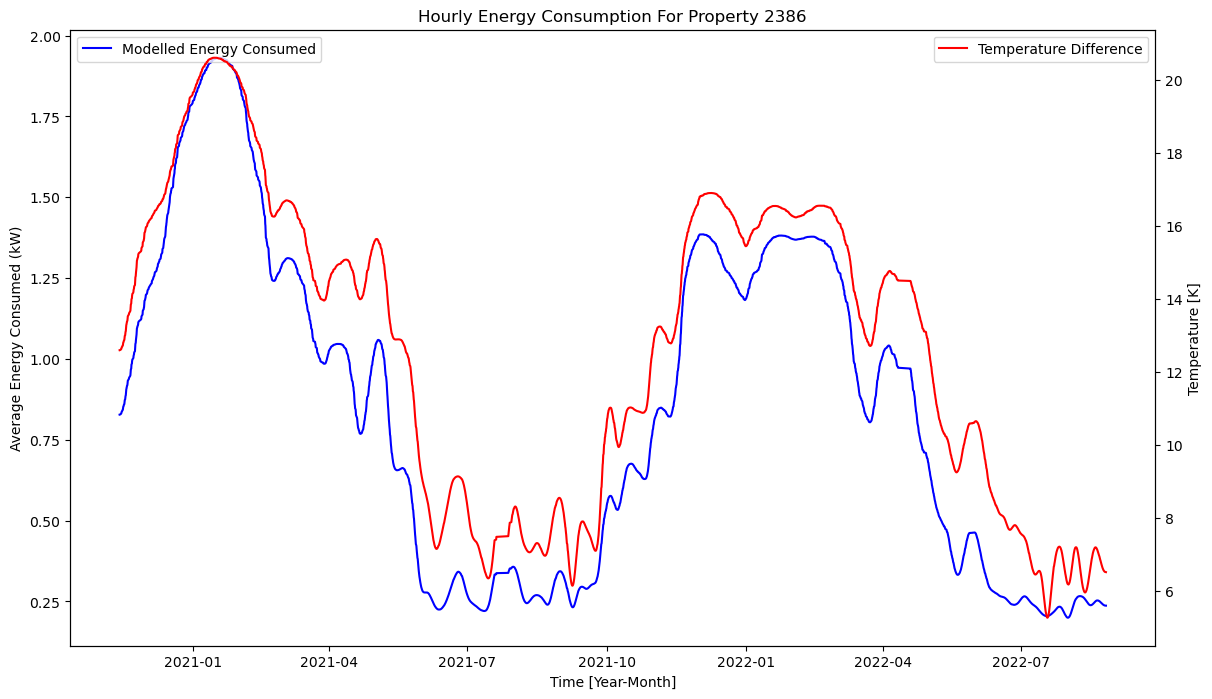

In [15]:
if option == "CSV":
    usage_categories = ['Low', 'Medium', 'High']
    for i, category in enumerate(usage_categories):
        if category == model_usage_categories:
            training_data = training_data[training_data['Usage_Categorisation'] == category]
            
            X = training_data[features]
            y = training_data[target]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model.fit(X_train, y_train)
            X_model = model_data[features]
            y_model = model.predict(X_model)        
    
            y_model = savgol_filter(gaussian_filter1d(y_model, sigma=interval), window_length=interval, polyorder=3)
            model_data['Temperature_Difference'] = savgol_filter(gaussian_filter1d(model_data['Temperature_Difference'], sigma=interval), window_length=interval, polyorder=3)
            model_data['Energy_Rolling'] = savgol_filter(gaussian_filter1d(model_data['Whole_System_Energy_Consumed'], sigma=interval), window_length=interval, polyorder=3)
            
            print(f"---------------------------------------------------------------------------------------")
            print(f"---------------------------------------------------------------------------------------")
            print(f"************************************ PROPERTY " + str(model_data['Property'].iloc[-1]) + f" ************************************")
            print(f"---------------------------------------------------------------------------------------")
            print(f"---------------------------------------------------------------------------------------")
            print(f"                                    CHARACTERISTICS                                    ")
            print(f"---------------------------------------------------------------------------------------")
            print(f"Property = " + str(model_data['Property'].iloc[-1]))
            print(f"Winter Energy Consumption = " + str(model_data['Total_Winter_Energy'].iloc[-1]) + f" kWh")
            print(f"SCOP = "  + str(model_data['SCOP'].iloc[-1]))
            print(f"Energy Consumption Categorisation = {category}")
            print(f"---------------------------------------------------------------------------------------")
            print(f"                                        RESULTS                                        ")
            print(f"---------------------------------------------------------------------------------------")
            filtered_data = model_data[(model_data['Timestamp'] >= pd.Timestamp('2021-12-01')) & (model_data['Timestamp'] <= pd.Timestamp('2022-03-01'))]
            filtered_y_model = y_model[(model_data['Timestamp'] >= pd.Timestamp('2021-12-01')) & (model_data['Timestamp'] <= pd.Timestamp('2022-03-01'))]
            area_actual_energy = trapezoid(filtered_data['Energy_Rolling'], (filtered_data['Timestamp'] - filtered_data['Timestamp'].min()) / pd.Timedelta(hours=1))
            area_modelled_energy = trapezoid(filtered_y_model, (filtered_data['Timestamp'] - filtered_data['Timestamp'].min()) / pd.Timedelta(hours=1))
            print(f"Total Actual Energy Consumed: {area_actual_energy:.3f} kWh")
            print(f"Total Modelled Energy Consumed: {area_modelled_energy:.3f} kWh")
            print(f"---------------------------------------------------------------------------------------")
            print(f"                                        METRICS                                        ")
            print(f"---------------------------------------------------------------------------------------")
            mae = mean_absolute_error(model_data['Energy_Rolling'], y_model)
            mse = mean_squared_error(model_data['Energy_Rolling'], y_model)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((model_data['Energy_Rolling'] - y_model) / model_data['Energy_Rolling'])) * 100
            print(f"Mean Absolute Error (MAE): {mae:.3f} kWh")
            print(f"Mean Squared Error (MSE): {mse:.3f} (kWh)²")
            print(f"Root Mean Squared Error (RMSE): {rmse:.3f} kWh")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f} %")
            print(f"---------------------------------------------------------------------------------------")
            print(f"***************************************************************************************")
            print(f"---------------------------------------------------------------------------------------")
            
            plt.figure(figsize=(14, 8))
            if interval % 2 == 0:
                plt.title(f'{int(interval)} Minute Energy Consumption For Property ' + str(model_data['Property'].iloc[-1]))
            if interval % 60 == 0:
                if interval/60 == 1:
                        plt.title(f'Hourly Energy Consumption For Property ' + str(model_data['Property'].iloc[-1]))
                if interval/60 > 1:
                    plt.title(f'{int(interval/60)} Hourly Energy Consumption For Property ' + str(model_data['Property'].iloc[-1]))
            if interval % 1440 == 0:
                if interval/1440 == 1:
                    plt.title(f'Daily Energy Consumption For Property ' + str(model_data['Property'].iloc[-1]))
                if interval/1440 > 1:
                    plt.title(f'{int(interval/1440)} Daily Energy Consumption For Property ' + str(model_data['Property'].iloc[-1]))
            plt.plot(model_data['Timestamp'], y_model, label='Modelled Energy Consumed', color='blue')
            plt.xlabel('Time [Year-Month]')
            plt.ylabel('Average Energy Consumed (kW)')
            plt.legend(loc='upper left')
            ax2 = plt.gca().twinx()
            ax2.plot(model_data['Timestamp'], model_data['Temperature_Difference'], label='Temperature Difference', color='red')
            ax2.set_ylabel('Temperature [K]')
            ax2.legend(loc='upper right')
            plt.show()

In [16]:
if option == "query":
    query_data = {}
    query_data['Timestamp'] = pd.to_datetime(query_timestamp)
    query_data['Internal_Air_Temperature'] = query_iat
    query_data['External_Air_Temperature'] = query_eat
    query_data['Temperature_Difference'] = query_iat - query_eat
    query_data['SCOP'] = query_scop
    query_data['Whole_System_Energy_Consumed'] = query_iat - query_eat
    query_data['Total_Winter_Energy'] = query_winter
    if query_winter <= 2250:
        query_category = 'Low'
        query_data['Usage_Categorisation'] = query_category
    elif 2250 < query_winter <= 3400:
        query_category = 'Medium'
        query_data['Usage_Categorisation'] = query_category
    else:
        query_category = 'High'
        query_data['Usage_Categorisation'] = query_category
    query_data = pd.DataFrame.from_dict(query_data, orient='index').T
    
    training_data = training_data[
        (training_data['Usage_Categorisation'] == query_category)
        & (abs(training_data['SCOP'] - query_scop) < 0.5)
        & (abs(training_data['Internal_Air_Temperature'] - query_iat) < 3)
        & (abs(training_data['External_Air_Temperature'] - query_eat) < 3)
        & (abs(training_data['Total_Winter_Energy'] - query_winter) < 500)
    ]
    
    if training_data.empty:
        print(f"No sufficient matching data found for the given query parameters.")
    else:
        X = training_data[features]
        y = training_data[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train) 
        X_query = query_data[features]
        y_query = model.predict(X_query)[0]

        print(f"---------------------------------------------------------------------------------------")
        print(f"---------------------------------------------------------------------------------------")
        print(f"**************************************** QUERY ****************************************")
        print(f"---------------------------------------------------------------------------------------")
        print(f"---------------------------------------------------------------------------------------")
        print(f"                                       PARAMETERS                                      ")
        print(f"---------------------------------------------------------------------------------------")
        print(f"Time = " + str(query_timestamp))
        print(f"Internal Air Temperature = " + str(query_iat) + f" °C")
        print(f"External Air Temperature = " + str(query_eat) + f" °C")
        print(f"SCOP = {query_scop}")
        print(f"Total Winter Energy Consumption = " + str(query_winter) + f" kWh")
        print(f"Energy Consumption = " + str(query_consumption) + f" kWh")
        print(f"---------------------------------------------------------------------------------------")
        print(f"                                        RESULTS                                        ")
        print(f"---------------------------------------------------------------------------------------")
        print(f"Predicted Energy Consumption = " + str(y_query) + f" kWh")    
        print(f"---------------------------------------------------------------------------------------")
        print(f"                                        METRICS                                        ")
        print(f"---------------------------------------------------------------------------------------")
        query_consumption = np.array([query_consumption])
        y_query = np.array([y_query])
        mae = mean_absolute_error(query_consumption, y_query)
        mse = mean_squared_error(query_consumption, y_query)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs(query_consumption - y_query) / query_consumption) * 100
        print(f"Mean Absolute Error (MAE): {mae:.3f} kWh")
        print(f"Mean Squared Error (MSE): {mse:.3f} (kWh)²")
        print(f"Root Mean Squared Error (RMSE): {rmse:.3f} kWh")
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f} %")
        print(f"---------------------------------------------------------------------------------------")
        print(f"***************************************************************************************")
        print(f"---------------------------------------------------------------------------------------")